🚌 Projet MDM - Mobilité Durable en Montagne ⛰️

*Author : Nicolas Grosjean*

*Date : 04/11/2025*

**Description :**

Compare the different datasets to

- fill the foreign keys to merge quickly
- find missing data
- find outdated data

In [1]:
# WORKING DIR NEED TO BE SET BEFORE IMPORTING SETTINGS
import os

os.chdir("../..")
print("Working directory set to the root of the project")

Working directory set to the root of the project


In [2]:
import folium
import geopandas as gpd
import pandas as pd
from rapidfuzz import fuzz

from src.settings import EPSG_WEB_MERCATOR, EPSG_WGS84

## Read data

In [3]:
from src.processors.c2c import C2CBusStopsProcessor

In [4]:
c2c_stops_gdf = C2CBusStopsProcessor.fetch(reload_pipeline=False)
c2c_stops_gdf.head()

,gtfs_id,navitia_id,osm_id,name,description,line_gtfs_ids,line_osm_ids,network,network_gtfs_id,geometry,other
0,None,stop_area:OGE:GEN15846,None,"Le Haut-Bréda, Pinsot le Village (Le Haut-Bréda)",None,[],[],Mobilités M - TouGo,None,POINT (679047.781 5677868.337),"{'srid': 3857, 'stoparea_id_and_line': [{'line..."
1,None,stop_area:OGE:GEN15852,None,"Le Haut-Bréda, Hot Pic Belle Etoile (Le Haut-B...",None,[],[],Mobilités M - TouGo,None,POINT (678910.858 5678497.283),"{'srid': 3857, 'stoparea_id_and_line': [{'line..."
2,None,stop_area:OGE:GEN15850,None,"Le Haut-Bréda, Chinfert (Le Haut-Bréda)",None,[],[],Mobilités M - TouGo,None,POINT (678788.406 5679655.482),"{'srid': 3857, 'stoparea_id_and_line': [{'line..."
3,None,stop_area:OGE:GEN15080,None,"Le Haut-Bréda, la Piat (Le Haut-Bréda)",None,[],[],Mobilités M - TouGo,None,POINT (678378.751 5675153.444),"{'srid': 3857, 'stoparea_id_and_line': [{'line..."
4,None,stop_area:OGE:GEN13054,None,"Domène, Domène Mairie (Domène)",None,[],[],Mobilités M - Tag,None,POINT (649900.998 5653440.123),"{'srid': 3857, 'stoparea_id_and_line': [{'line..."


In [5]:
c2c_expanded = c2c_stops_gdf["other"].apply(pd.Series)
c2c_expanded_stops_gdf = pd.concat(
    [c2c_stops_gdf.drop(columns=["other"]), c2c_expanded], axis=1
)
c2c_expanded_stops_gdf.head()

,gtfs_id,navitia_id,osm_id,name,description,line_gtfs_ids,line_osm_ids,network,network_gtfs_id,geometry,srid,stoparea_id_and_line
0,None,stop_area:OGE:GEN15846,None,"Le Haut-Bréda, Pinsot le Village (Le Haut-Bréda)",None,[],[],Mobilités M - TouGo,None,POINT (679047.781 5677868.337),3857,"[{'line': 'Bus 79 - ALLEVARD ECOLE PLEIADE', '..."
1,None,stop_area:OGE:GEN15852,None,"Le Haut-Bréda, Hot Pic Belle Etoile (Le Haut-B...",None,[],[],Mobilités M - TouGo,None,POINT (678910.858 5678497.283),3857,"[{'line': 'Bus 79 - ALLEVARD ECOLE PLEIADE', '..."
2,None,stop_area:OGE:GEN15850,None,"Le Haut-Bréda, Chinfert (Le Haut-Bréda)",None,[],[],Mobilités M - TouGo,None,POINT (678788.406 5679655.482),3857,"[{'line': 'Bus 79 - ALLEVARD ECOLE PLEIADE', '..."
3,None,stop_area:OGE:GEN15080,None,"Le Haut-Bréda, la Piat (Le Haut-Bréda)",None,[],[],Mobilités M - TouGo,None,POINT (678378.751 5675153.444),3857,"[{'line': 'Bus 79 - ALLEVARD ECOLE PLEIADE', '..."
4,None,stop_area:OGE:GEN13054,None,"Domène, Domène Mairie (Domène)",None,[],[],Mobilités M - Tag,None,POINT (649900.998 5653440.123),3857,[{'line': 'Bus 15 - GRENOBLE Verdun - Préfectu...


In [6]:
c2c_expanded_stops_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   gtfs_id               0 non-null      object  
 1   navitia_id            650 non-null    object  
 2   osm_id                0 non-null      object  
 3   name                  650 non-null    object  
 4   description           0 non-null      object  
 5   line_gtfs_ids         650 non-null    object  
 6   line_osm_ids          650 non-null    object  
 7   network               650 non-null    object  
 8   network_gtfs_id       0 non-null      object  
 9   geometry              650 non-null    geometry
 10  srid                  650 non-null    int64   
 11  stoparea_id_and_line  650 non-null    object  
dtypes: geometry(1), int64(1), object(10)
memory usage: 61.1+ KB


In [7]:
len(c2c_expanded_stops_gdf["navitia_id"].unique())

632

In [8]:
tdg_stops_gdf = gpd.read_parquet(
    os.path.join(os.getcwd(), "src/data/transportdatagouv/stops_38.parquet")
)
tdg_stops_gdf.head()

,agency_id,agency_name,stop_id,stop_name,stop_code,stop_desc,stop_lines,geometry
0,CARSxREGIONxAIN:Network:1:LOC,REGION - cars Région Ain,FR:38261:ZE:38367:CARSxREGIONxAIN,La gare,1136154,<NA>,{'line_id': 'CARSxREGIONxAIN:FlexibleLine:1005...,POINT (608999.29 5727934.37)
1,CARSxREGIONxAIN:Network:1:LOC,REGION - cars Région Ain,FR:38055:ZE:38540:CARSxREGIONxAIN,Mairie,1137588,<NA>,{'line_id': 'CARSxREGIONxAIN:FlexibleLine:1005...,POINT (615432.365 5731543.476)
2,CARSxREGIONxAIN:Network:1:LOC,REGION - cars Région Ain,FR:38465:ZE:38541:CARSxREGIONxAIN,Place,1137590,<NA>,{'line_id': 'CARSxREGIONxAIN:FlexibleLine:1005...,POINT (612596.334 5731950.939)
3,ARDECHE:Network:1:LOC,REGION - cars Région Ardèche,FR:38298:ZE:40822:ARDECHE,Gare SNCF,1023073,<NA>,"{'line_id': 'ARDECHE:Line:1000601:LOC', 'line_...",POINT (533823.813 5680267.662)
4,ARDECHE:Network:1:LOC,REGION - cars Région Ardèche,FR:38349:ZE:41169:ARDECHE,Mairie,1027195,<NA>,"{'line_id': 'ARDECHE:Line:1000601:LOC', 'line_...",POINT (531434.796 5671771.274)


In [9]:
tdg_stops_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15026 entries, 0 to 15025
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   agency_id    15026 non-null  object  
 1   agency_name  15026 non-null  object  
 2   stop_id      15026 non-null  string  
 3   stop_name    15026 non-null  string  
 4   stop_code    12571 non-null  string  
 5   stop_desc    8 non-null      string  
 6   stop_lines   15026 non-null  object  
 7   geometry     15026 non-null  geometry
dtypes: geometry(1), object(3), string(4)
memory usage: 939.3+ KB


## Navitia ids are not the GTFS ids

In [10]:
c2c_expanded_stops_gdf.merge(tdg_stops_gdf, left_on="navitia_id", right_on="stop_id")

,gtfs_id,navitia_id,osm_id,name,description,line_gtfs_ids,line_osm_ids,network,network_gtfs_id,geometry_x,srid,stoparea_id_and_line,agency_id,agency_name,stop_id,stop_name,stop_code,stop_desc,stop_lines,geometry_y


## Merge C2C and TDG with distance

In [11]:
interesting_columns = [
    "navitia_id",
    "name",
    "network",
    "agency_name",
    "stop_id",
    "stop_name",
    "distance",
]
c2c_tdg_stops_gdf = gpd.sjoin_nearest(
    c2c_expanded_stops_gdf.to_crs(EPSG_WEB_MERCATOR),
    tdg_stops_gdf.to_crs(EPSG_WEB_MERCATOR),
    how="left",
    distance_col="distance",
)
c2c_tdg_stops_gdf[interesting_columns].head()

,navitia_id,name,network,agency_name,stop_id,stop_name,distance
0,stop_area:OGE:GEN15846,"Le Haut-Bréda, Pinsot le Village (Le Haut-Bréda)",Mobilités M - TouGo,M Réso - Grésivaudan,S10748,"Le Haut-Bréda, Pinsot Le Village",2.260377e-09
0,stop_area:OGE:GEN15846,"Le Haut-Bréda, Pinsot le Village (Le Haut-Bréda)",Mobilités M - TouGo,M Réso - Grésivaudan,10748,"Le Haut-Bréda, Pinsot Le Village",2.260377e-09
1,stop_area:OGE:GEN15852,"Le Haut-Bréda, Hot Pic Belle Etoile (Le Haut-B...",Mobilités M - TouGo,M Réso - Grésivaudan,S10222,"Le Haut-Bréda, Hot Pic Belle Étoile",1.401826e-09
2,stop_area:OGE:GEN15850,"Le Haut-Bréda, Chinfert (Le Haut-Bréda)",Mobilités M - TouGo,M Réso - Grésivaudan,10109,"Le Haut-Bréda, Chinfert",1.583420e-09
2,stop_area:OGE:GEN15850,"Le Haut-Bréda, Chinfert (Le Haut-Bréda)",Mobilités M - TouGo,M Réso - Grésivaudan,S10109,"Le Haut-Bréda, Chinfert",1.583420e-09


In [12]:
# Remove () and put lower in C2C names
c2c_tdg_stops_gdf["name2"] = c2c_tdg_stops_gdf["name"].apply(
    lambda s: s[: s.index("(")].lower()
)
c2c_tdg_stops_gdf["name2"]

0         le haut-bréda, pinsot le village 
0         le haut-bréda, pinsot le village 
1      le haut-bréda, hot pic belle etoile 
2                  le haut-bréda, chinfert 
2                  le haut-bréda, chinfert 
                       ...                 
645                                  école 
646                              les égaux 
647                             gérentière 
648                  école de saint-hugues 
649                           saint-hugues 
Name: name2, Length: 716, dtype: object

In [13]:
# Put lower in TDG names
c2c_tdg_stops_gdf["stop_name2"] = c2c_tdg_stops_gdf["stop_name"].apply(lambda s: s.lower())

In [14]:
# Add fuzzymatching on names
interesting_columns2 = [
    "navitia_id",
    "name",
    "network",
    "agency_name",
    "stop_id",
    "stop_name",
    "distance",
    "fuzz_ratio",
]
c2c_tdg_stops_gdf["fuzz_ratio"] = c2c_tdg_stops_gdf.apply(
    lambda row: fuzz.ratio(row["name2"], row["stop_name2"]), axis=1
)
c2c_tdg_stops_gdf[interesting_columns2].head()

,navitia_id,name,network,agency_name,stop_id,stop_name,distance,fuzz_ratio
0,stop_area:OGE:GEN15846,"Le Haut-Bréda, Pinsot le Village (Le Haut-Bréda)",Mobilités M - TouGo,M Réso - Grésivaudan,S10748,"Le Haut-Bréda, Pinsot Le Village",2.260377e-09,98.461538
0,stop_area:OGE:GEN15846,"Le Haut-Bréda, Pinsot le Village (Le Haut-Bréda)",Mobilités M - TouGo,M Réso - Grésivaudan,10748,"Le Haut-Bréda, Pinsot Le Village",2.260377e-09,98.461538
1,stop_area:OGE:GEN15852,"Le Haut-Bréda, Hot Pic Belle Etoile (Le Haut-B...",Mobilités M - TouGo,M Réso - Grésivaudan,S10222,"Le Haut-Bréda, Hot Pic Belle Étoile",1.401826e-09,95.774648
2,stop_area:OGE:GEN15850,"Le Haut-Bréda, Chinfert (Le Haut-Bréda)",Mobilités M - TouGo,M Réso - Grésivaudan,10109,"Le Haut-Bréda, Chinfert",1.583420e-09,97.872340
2,stop_area:OGE:GEN15850,"Le Haut-Bréda, Chinfert (Le Haut-Bréda)",Mobilités M - TouGo,M Réso - Grésivaudan,S10109,"Le Haut-Bréda, Chinfert",1.583420e-09,97.872340


In [15]:
# Explore big distance to see where to cut
c2c_tdg_stops_gdf_sorted = c2c_tdg_stops_gdf[interesting_columns2].sort_values("distance")
c2c_tdg_stops_gdf_sorted[c2c_tdg_stops_gdf_sorted["distance"] > 200]

,navitia_id,name,network,agency_name,stop_id,stop_name,distance,fuzz_ratio
634,stop_area:OGE:GEN14410,"Le Haut-Bréda, les Millets C.V.O. (Le Haut-Bréda)",Mobilités M - TouGo,M Réso - Grésivaudan,10634,"Le Haut-Bréda, La Ferrière Les Millets",203.341238,71.232877
423,stop_area:O38:3223251,Mairie (Pierre-Châtel),Isère - Transisère,REGION - cars Région Isère,FR:38304:ZE:509:ISERE,ARRET SUD,208.281790,50.000000
401,stop_area:O38:3223807,La Tour (Saint-Nizier-du-Moucherotte),Isère - Transisère,REGION - cars Région Isère,FR:38433:ZE:1500:ISERE,LA TOUR,216.380808,93.333333
512,stop_area:O38:3223338,Ballatin (Les Deux Alpes),Isère - Transisère,REGION - cars Région Isère,FR:38253:ZE:655:ISERE,TELECABINE VENOSC,238.526957,38.461538
547,stop_area:O38:3440408,Camping la Bérarde (Saint-Christophe-en-Oisans),Isère - Transisère,REGION - cars Région Isère,FR:38375:ZE:59073:ISERE,COMBE NOIRE,393.020872,33.333333
513,stop_area:O38:3601070,Le Sellier (Les Deux Alpes),Isère - Transisère,REGION - cars Région Isère,FR:38253:ZE:655:ISERE,TELECABINE VENOSC,459.375651,35.714286
510,stop_area:O38:3546474,Bourg dArud Camping (Les Deux Alpes),Isère - Transisère,REGION - cars Région Isère,FR:38253:ZE:655:ISERE,TELECABINE VENOSC,609.229997,27.027027
509,stop_area:O38:3223343,LAlleau (Les Deux Alpes),Isère - Transisère,REGION - cars Région Isère,FR:38253:ZE:656:ISERE,TELECABINE VENOSC,802.891773,32.000000
97,stop_area:OGR:EYT,"Saint-Nazaire-les-Eymes, les Tourterelles (Sai...",Mobilités M - Tag,M Réso - Métropole Grenobloise,10585,"Saint-Nazaire-les-Eymes, Les Eymes",869.991277,84.210526
97,stop_area:OGR:EYT,"Saint-Nazaire-les-Eymes, les Tourterelles (Sai...",Mobilités M - Tag,M Réso - Métropole Grenobloise,13309,"Saint-Nazaire-les-Eymes, Les Eymes",869.991277,84.210526


In [16]:
c2c_tdg_max_dist = 220  # m
print(f"Remove matching at distance bigger than {c2c_tdg_max_dist}m")

Remove matching at distance bigger than 220m


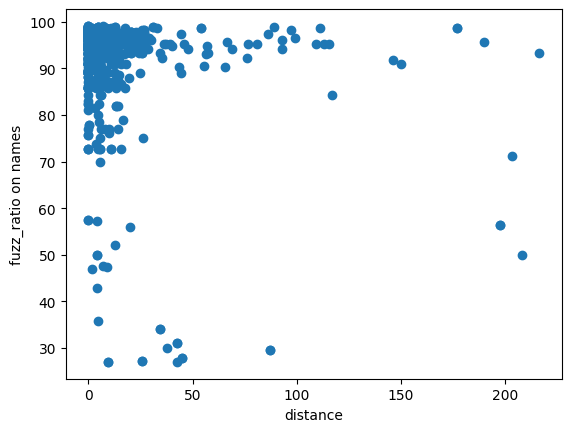

In [17]:
import matplotlib.pyplot as plt

c2c_tdg_stops_gdf2 = c2c_tdg_stops_gdf[c2c_tdg_stops_gdf["distance"] < c2c_tdg_max_dist]
plt.scatter(c2c_tdg_stops_gdf2["distance"], c2c_tdg_stops_gdf2["fuzz_ratio"])
plt.xlabel("distance")
plt.ylabel("fuzz_ratio on names")
plt.show()

In [18]:
# Explore bad fuzzy matching with some distance
c2c_tdg_stops_gdf2_sorted = c2c_tdg_stops_gdf2[
    (c2c_tdg_stops_gdf2["fuzz_ratio"] < 60) & (c2c_tdg_stops_gdf2["distance"] > 10)
].sort_values("fuzz_ratio", ascending=False)
c2c_tdg_stops_gdf2_sorted[interesting_columns2]

,navitia_id,name,network,agency_name,stop_id,stop_name,distance,fuzz_ratio
204,stop_area:OGR:LOP,"Lumbin, Longs Prés (Lumbin)",Mobilités M - Tag,M Réso - Grésivaudan,10062,"Lumbin, Carrefour ZI",197.398162,56.410256
204,stop_area:OGR:LOP,"Lumbin, Longs Prés (Lumbin)",Mobilités M - Tag,M Réso - Grésivaudan,S10062,"Lumbin, Carrefour ZI",197.398162,56.410256
385,stop_area:O38:3279185,La Poya (Fontaine),Isère - Transisère,M Réso - Métropole Grenobloise,1612,"Fontaine, La Poya",20.057033,56.000000
420,stop_area:O38:3223427,Sagnes(Prénatier) (Villard-de-Lans),Isère - Transisère,REGION - cars Région Isère,FR:38548:ZE:821:ISERE,SAGNES(PRENATIER),12.808334,52.173913
423,stop_area:O38:3223251,Mairie (Pierre-Châtel),Isère - Transisère,REGION - cars Région Isère,FR:38304:ZE:509:ISERE,ARRET SUD,208.281790,50.000000
200,stop_area:O38:3227238,Montfort Funiculaire (Crolles) (Lumbin),Isère - Transisère,Mobilités M - Covoit Lignes +,S428,"Lumbin, Crolles - Montfort",34.481330,34.042553
200,stop_area:O38:3227238,Montfort Funiculaire (Crolles) (Lumbin),Isère - Transisère,Mobilités M - Covoit Lignes +,428,"Lumbin, Crolles - Montfort",34.481330,34.042553
458,stop_area:O38:3223135,La Poste (Monestier-de-Clermont),Isère - Transisère,TER BreizhGo,SNCF:87697524,Gare de Monestier-de-Clermont Centre,42.520128,31.111111
458,stop_area:O38:3223135,La Poste (Monestier-de-Clermont),Isère - Transisère,TER BreizhGo,87697524,Gare de Monestier-de-Clermont Centre,42.520128,31.111111
270,stop_area:OGE:GEN17010,"Chapareillan, Chapareillan Mairie (Chapareillan)",Mobilités M - TouGo,REGION - cars Région Isère,FR:38075:ZE:3866:ISERE,MAIRIE,37.612095,30.000000


In [19]:
min_fuzz_ratio = 60
max_fuzz_ratio_dist = 21
print(
    f"Remove matching when distance is bigger than {max_fuzz_ratio_dist}m and fuzz ratio lower than {min_fuzz_ratio}"
)

Remove matching when distance is bigger than 21m and fuzz ratio lower than 60


In [20]:
c2c_tdg_stops_gdf3 = c2c_tdg_stops_gdf2[
    (c2c_tdg_stops_gdf2["fuzz_ratio"] > min_fuzz_ratio)
    | (c2c_tdg_stops_gdf2["distance"] < max_fuzz_ratio_dist)
]

In [21]:
merge_nb = len(c2c_tdg_stops_gdf3["navitia_id"].unique())
total_nb = len(c2c_expanded_stops_gdf["navitia_id"].unique())
print(f"{merge_nb} C2C stops merged on {total_nb} ({merge_nb / total_nb:.0%})")

606 C2C stops merged on 632 (96%)


In [22]:
no_merge_points = gpd.GeoDataFrame(
    c2c_expanded_stops_gdf["geometry"][
        ~c2c_expanded_stops_gdf["geometry"].isin(c2c_tdg_stops_gdf3["geometry"])
    ].unique()
)
no_merge_points.columns = ["geometry"]
no_merge_points.set_geometry("geometry", inplace=True)
no_merge_points

,geometry
0,POINT (685175.696 5616486.406)
1,POINT (632489.517 5574622.513)
2,POINT (632531.818 5573222.168)
3,POINT (650538.859 5662758.381)
4,POINT (603933.73 5754900.913)
5,POINT (604877.162 5755724.04)
6,POINT (651355.944 5667309.583)
7,POINT (587121.592 5715710.893)
8,POINT (656729.559 5668674.603)
9,POINT (657574.251 5669317.782)


In [79]:
# Plot points we failed to merge


# Add a base OSM map centered on Grenoble
m = folium.Map(location=[45.1885, 5.7245], zoom_start=9, tiles="OpenStreetMap")

# Add Waymarked Trails hiking layers
folium.TileLayer(tiles="WaymarkedTrails.hiking").add_to(m)

folium.GeoJson(
    no_merge_points,
    name="C2C stop areas not merged with Transport Data Gouv",
    zoom_on_click=True,
    marker=folium.Marker(icon=folium.Icon(icon="star")),
).add_to(m)
m

In [25]:
c2c_expanded_stops_gdf[~c2c_expanded_stops_gdf["geometry"].isin(c2c_tdg_stops_gdf3["geometry"])]

,gtfs_id,navitia_id,osm_id,name,description,line_gtfs_ids,line_osm_ids,network,network_gtfs_id,geometry,srid,stoparea_id_and_line
14,None,stop_area:O38:3440068,None,Passerelle de Lanchatra (Saint-Christophe-en-O...,None,[],[],Isère - Transisère,None,POINT (685175.696 5616486.406),3857,[{'line': 'Bus T77 - BOURG DOISANS-LA BERARDE'...
24,None,stop_area:R26:COM_26-04054A,None,Les Oddolayes (Lus-la-Croix-Haute),None,[],[],Drôme - Réseau interurbain 26,None,POINT (632489.517 5574622.513),3857,[{'line': 'Bus 26-20016 - SCO LUS LA CROIX HAU...
25,None,stop_area:R26:COM_26-10381A,None,Les Lussettes (Lus-la-Croix-Haute),None,[],[],Drôme - Réseau interurbain 26,None,POINT (632531.818 5573222.168),3857,[{'line': 'Bus 26-20016 - SCO LUS LA CROIX HAU...
97,None,stop_area:OGR:EYT,None,"Saint-Nazaire-les-Eymes, les Tourterelles (Sai...",None,[],[],Mobilités M - Tag,None,POINT (650538.859 5662758.381),3857,[{'line': 'Bus 85 - LA TRONCHE Grand Sablon / ...
115,None,stop_area:R01:Navitia:300638,None,Gare (Villebois),None,[],[],Ain - Réseau interurbain 01,None,POINT (603933.73 5754900.913),3857,"[{'line': 'Bus A49 - AMBERIEU / LHUIS', 'stopa..."
118,None,stop_area:R01:Navitia:300639,None,Allée des Tilleuls (Villebois),None,[],[],Ain - Réseau interurbain 01,None,POINT (604877.162 5755724.04),3857,"[{'line': 'Bus A49 - AMBERIEU / LHUIS', 'stopa..."
140,None,stop_area:OGR:PPME,None,"Plateau-des-Petites-Roches, les Meunières (Pla...",None,[],[],Mobilités M - Tag,None,POINT (651355.944 5667309.583),3857,[{'line': 'Bus 85 - LA TRONCHE Grand Sablon / ...
177,None,stop_area:OIA:2232425,None,Rue Libération (Bourgoin-Jallieu),None,[],[],CAPI - Ruban,None,POINT (587121.592 5715710.893),3857,"[{'line': 'Bus 4 - 4', 'stoparea_id': 331}, {'..."
200,None,stop_area:O38:3227238,None,Montfort Funiculaire (Crolles) (Lumbin),None,[],[],Isère - Transisère,None,POINT (656729.559 5668674.603),3857,[{'line': 'Bus T83 - CHAMBERY-CHAPAREILLAN-GRE...
204,None,stop_area:OGR:LOP,None,"Lumbin, Longs Prés (Lumbin)",None,[],[],Mobilités M - Tag,None,POINT (657574.251 5669317.782),3857,[{'line': 'Bus C11 - LUMBIN Longs Prés / VOIRO...
